In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as spi
from scipy.optimize import least_squares
import scipy.signal as ssi
from numpy.lib.stride_tricks import sliding_window_view
import scipy.io.wavfile

In [3]:
def read_hawk(path):
  data = pd.read_csv(path)
  gyroscale = np.pi/180
  ts,xs,ys,zs = data.values[:,[1,2,3,4]].T
  return np.vstack(((ts - ts[0]) / 1e6, ys*gyroscale, zs*gyroscale, xs*gyroscale)).astype(np.float64)
def read_rc(path):
  data = pd.read_csv(path)
  gyroscale = 500 / 2**15 * np.pi/180
  ts,xs,ys,zs = data.values[:,[0,1,2,3]].T
  return np.vstack((ts/1e3, zs*gyroscale, xs*gyroscale, -ys*gyroscale)).astype(np.float64)

In [4]:
hawk_data = read_hawk('../hawk.csv')
rc_data = read_rc('../rc.csv')

In [30]:
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import warnings

def motion_model(timestamps, tvels, init=None):
  def m(accs):
    dts = timestamps[1:] - timestamps[:-1]
    vels = np.zeros_like(tvels)
    vels[0] =  tvels[0] if init is None else init
    vels[1:] = np.cumsum(accs * dts) + vels[0]
    return vels

  def evaluate(accs):
    return m(accs) - tvels

  def jac(accs):
    dts = timestamps[1:] - timestamps[:-1]
    derivs = np.zeros((len(tvels), len(accs)))
    for j in range(len(accs)):
      derivs[1:,j] = np.array(dts * (np.arange(1,len(tvels)) > j), dtype=np.float64)
      derivs[0,j] = 0
    return derivs

  def predict(accs, tss):
    return np.interp(tss, timestamps, m(accs))

  return (evaluate, jac, predict)

def proc_axis(hawk):
  alpha = 1e-3
  state_size = 500
  window_size = 100
  drop_size = 40
  window = []
  new_smpl_dt = 1e-3
  new_data = [[0],[0]]

  next_init = None

  cc = 0
  for sample in hawk.T:
    time, value = sample[0], sample[1]

    if len(window) < window_size: 
      #time - window[0][0] < window_size:
      # add new data into window
      window.append((time, value))
      continue

    # generate new samples
    state = np.zeros(len(window) - 1)
    window_snapshot = np.array(window, dtype=np.float64)
    residuals, jac, predict = motion_model(window_snapshot[:,0], window_snapshot[:,1], next_init)

    result = least_squares(residuals, state, bounds = (-6, 6),  method='trf', ftol=1e-3, loss='soft_l1')
    accs = result.x

    new_smpl_times = np.arange(new_data[0][-1], (window[-1][0] + window[0][0]) / 2, new_smpl_dt)
    new_smpl_vals = predict(accs, new_smpl_times)

    new_data[0].extend(new_smpl_times)
    new_data[1].extend(new_smpl_vals)

    print(len(new_data[0]))
  
    # drop samples from window
    window = window[drop_size:]

    next_init = predict(accs, [window[0][0]])[0]

    if cc % 800 == 0 and cc != 0:
      print(time / hawk[0][-1] * 100)
      break
    cc += 1
  return np.array(new_data, dtype = np.float64)

def proc_all(hawk_data):
  hawk_X = hawk_data[[0,1],:]
  hawk_Y = hawk_data[[0,2],:]
  hawk_Z = hawk_data[[0,3],:]
  fixed_X = proc_axis(hawk_X)
  #fixed_Y = proc_axis(hawk_Y)
  #fixed_Z = proc_axis(hawk_Z)
  return np.vstack((fixed_X[0], fixed_X[1], fixed_X[1], fixed_X[1]))

hawk_fixed = proc_all(hawk_data)


72
134
185
236
289
337
390
439
490
547
600
651
700
750
804
847
904
948
1000
1054
1101
1156
1209
1257
1310
1359
1411
1466
1512
1561
1613
1657
1713
1758
1814
1862
1914
1959
2013
2058
2121
2165
2218
2271
2319
2369
2418
2473
2522
2566
2622
2666
2721
2766
2819
2864
2920
2967
3016
3070
3126
3169
3226
3277
3329
3385
3437
3498
3551
3601
3675
3718
3778
3823
3878
3923
3974
4025
4079
4125
4180
4223
4275
4326
4374
4432
4481
4538
4587
4635
4686
4734
4779
4836
4885
4929
4980
5034
5078
5134
5179
5229
5281
5337
5380
5439
5483
5533
5587
5631
5687
5730
5783
5828
5883
5927
5983
6028
6081
6125
6182
6232
6276
6327
6379
6433
6485
6529
6596
6641
6697
6743
6794
6847
6903
6950
7006
7051
7105
7169
7221
7265
7328
7373
7423
7479
7523
7577
7633
7687
7738
7788
7839
7884
7939
7983
8039
8089
8138
8183
8245
8295
8351
8396
8446
8500
8545
8596
8654
8699
8759
8803
8852
8903
8953
9004
9053
9104
9148
9203
9256
9305
9349
9406
9451
9499
9548
9593
9652
9696
9753
9807
9851
9906
9957
10006
10055
10101
10156
10204
10255
10306
10

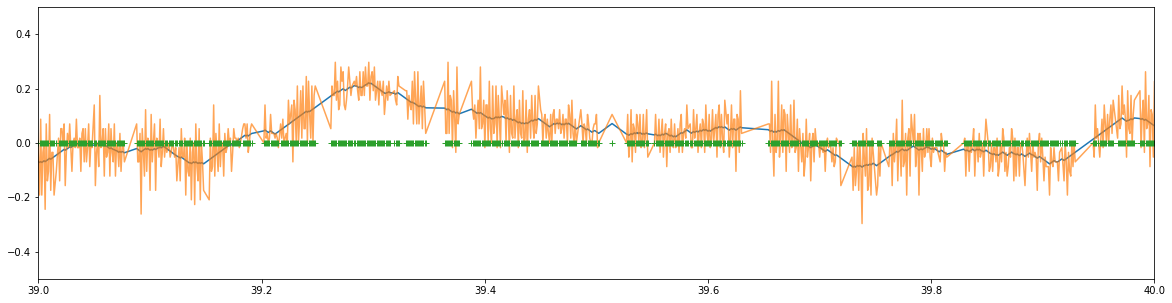

In [28]:
plt.figure(figsize=(20,5))
plt.xlim(39,40)
plt.ylim(-.5,.5)
plt.plot(hawk_fixed[0], hawk_fixed[1], '-')
plt.plot(hawk_data[0], hawk_data[1], '-', alpha=.7)
plt.plot(hawk_data[0], np.zeros((len(hawk_data[0]),)),'+')

In [6]:
new_data = np.hstack((
      np.arange(len(hawk_fixed[0]))[np.newaxis].T, \
      (np.array(hawk_fixed[0])[np.newaxis].T + 10) * 1e6, \
      np.array(hawk_fixed[3])[np.newaxis].T * 180 / np.pi, \
      np.array(hawk_fixed[1])[np.newaxis].T * 180 / np.pi, \
      np.array(hawk_fixed[2])[np.newaxis].T * 180 / np.pi \
    ))
new_df = pd.DataFrame(new_data, columns=['loopIteration','time','gyroADC[0]','gyroADC[1]','gyroADC[2]'])
new_df.to_csv("hawk_smooth1000.csv",index=False)

c:\Users\Dell\Videos\rc+firefly\resampler\_venv_\lib\site-packages\matplotlib\axes\_axes.py:7580: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


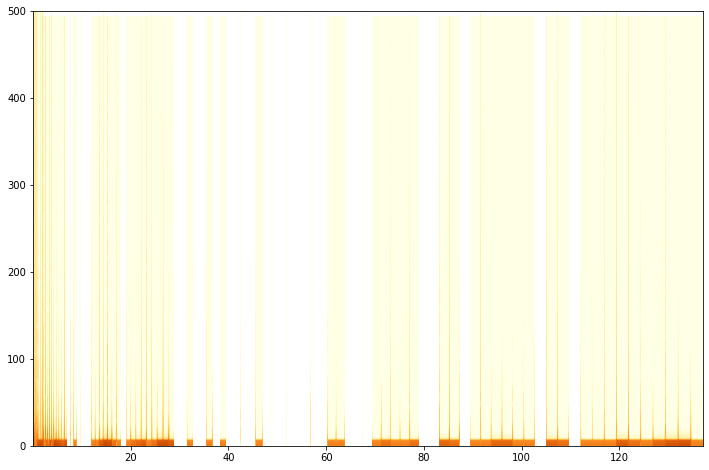

In [7]:
plt.figure(figsize=(12, 8))
plt.specgram(hawk_fixed[1], Fs=1000, cmap='YlOrBr', vmin=-100, vmax=0)
plt.axis(ymin=0, ymax=500)
None

In [8]:
scipy.io.wavfile.write('hawk_blackman.wav', 8000, np.array(hawk_data[1]))

In [9]:
def motion_model(timestamps, tvels):
  def m(accs):
    dts = timestamps[1:] - timestamps[:-1]
    vels = np.zeros_like(tvels)
    vels[0] = tvels[0]
    vels[1:] = np.cumsum(accs * dts) + vels[0]
    return vels

  def evaluate(accs):
    return m(accs) - tvels

  def jac(accs):
    dts = timestamps[1:] - timestamps[:-1]
    derivs = np.zeros((len(tvels), len(accs)))
    for j in range(len(accs)):
      derivs[1:,j] = np.array(dts * (np.arange(1,len(tvels)) > j), dtype=np.float64)
      derivs[0,j] = 0
    return derivs

  def predict(accs, tss):
    return np.interp(tss, timestamps, m(accs))

  return (evaluate, jac, predict)

In [10]:
ev, jac, pr = motion_model(np.array([0,1,2,3,4,5]), np.array([0,0,0,0,0,0]))
ev([0,1,-1,0,0])
pr([0,1,-1,0,0], [1])

array([0.])

In [11]:
jac([0,1,-1,0,0])


array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]])